# Short Introduction to Great Expectations Concepts on Hopsworks

The purpose of this notebook is to give a brief introduction to Great Expectations concepts and classes which are relevant for integration with the Hopsworks MLOps platform. Hopsworks works out of the box with Great Expectations classes, so no need to learn new abstractions and syntax. Define your Expectation Suite, register it to your Feature Group and try inserting data. Hopsworks take care of the rest!

In [ ]:
!pip install -U hopsworks --quiet

In [ ]:
import great_expectations as ge
import pandas as pd
from pprint import pprint

## Load example data and create a Feature Group

In [ ]:
# Transactions data used in the fraud detection tutorial
trans_df = pd.read_csv("https://repo.hops.works/master/hopsworks-tutorials/data/card_fraud_data/transactions.csv", parse_dates=["datetime"])
trans_df.head(3)

In [ ]:
# login in hopsworks

import hopsworks
project = hopsworks.login()
fs = project.get_feature_store()

In [ ]:
trans_fg = fs.get_or_create_feature_group(
    name="mini_transactions_fraud_batch_fg",
    version=1,
    description="Transaction data",
    primary_key=['cc_num'],
    event_time='datetime'
)

# Insert a single row to persist the FG in the backend
trans_fg.insert(trans_df.head(1))

## Great Expectations Classes and Concepts

### Expectations

The central concept is the Expectation. Each type of expectation specifies one or more metrics whose values will be computed on a DataFrame. The configuration of a given expectation type specifies an acceptable range to be compared to the observed value(s). Expectation entities are not specific to your data or a particular DataFrame, they merely define operations to be performed and their success criteria. 

During development or prototyping, Great Expectations offers a DataFrame wrapper to explore your data. It enables an auto-completion method for core supported expectations. As different expectations will require different kwargs for their configuration, it helps gaining familiarity with new expectations.

In Hopsworks, expectations will usually be evaluated on a Feature or pair of Feature. The expectation type enables a standardisation of the metrics computed while the configuration allows the user to adapt the success of the validation to their particular conditions. In a production setup, each Feature will be validated by multiple expectations. Note that Hopsworks populates the meta field of an expectation with an id to enable smoother integrations.

In [ ]:
ge_df = ge.from_pandas(trans_df)
result = ge_df.expect_column_mean_to_be_between(column="amount", min_value=10, max_value=100)
print(f"Observed mean : {result['result']['observed_value']}, success : {result['success']}")

### Validation Result

An expectation generates a validation result entity on evaluation. This result is specific to a DataFrame and acts as a log for the evaluation. There are different information metrics in the validation result:
- The success or failure of the evaluation, meaning are the metrics calculated with the success criteria specified in the expectations.
- A meta field for extra information
- An expectation_config field which contains the entity that was evaluated against the DataFrame. Crucial for reproducibility, still needs the same data.
- An exception_info, in case the evaluation raised an exception.
- The result field itself, with information about the computed metrics. The type of information depends on the expectation_type.

When the expectation has an Hopsworks id, the result can be linked to the expectation on upload. This allows a history of data validation to start being populated to simplify validation monitoring.

In [ ]:
pprint(result)

### Expectation Suite

The Expectation Suite is another central concept of Great Expectations relevant to working with Hopsworks. The suite is simply a collection of Expectations to be evaluated against a DataFrame. It provides persistence for the expectation types and configurations to be run. 

Expectation suites are the core abstraction used to integrate with Hopsworks. Each version of a Feature Group will have a unique expectation suite used to validate data before their insertion into the Feature Store. All expectations connected to a given Feature should be included in the suite as well as all expectations performed on pair of Features. The expectation suite is attached to a Feature Group in the backend, enabling convenient storage and retrieval. In addition, Hopsworks is configured by default to use the suite to automatically run validation on insertion.

In [ ]:
new_expectation_suite = ge.core.ExpectationSuite(
    expectation_suite_name="expectation_suite_101"
    )

new_expectation_suite.add_expectation(result['expectation_config'])

# # equivalent to 
# new_expectation_suite.add_expectation(
#     ge.core.ExpectationConfiguration(
#         expectation_type="expect_column_mean_to_be_between",
#         kwargs={
#             "column":"amount",
#             "min_value":10,
#             "max_value":100
#         }
#     )
# )

In [ ]:
# Run the validation manually with Great Expectations
ge_df = ge.from_pandas(trans_df, expectation_suite=new_expectation_suite)
report = ge_df.validate()

# Or setup automatic validation on insert with Hopsworks in a single line of code
trans_fg.save_expectation_suite(
    expectation_suite=new_expectation_suite,
    validation_ingestion_policy="ALWAYS")

You can also edit your expectation suite or checkout its list of expectation in Hopsworks UI for convenience.

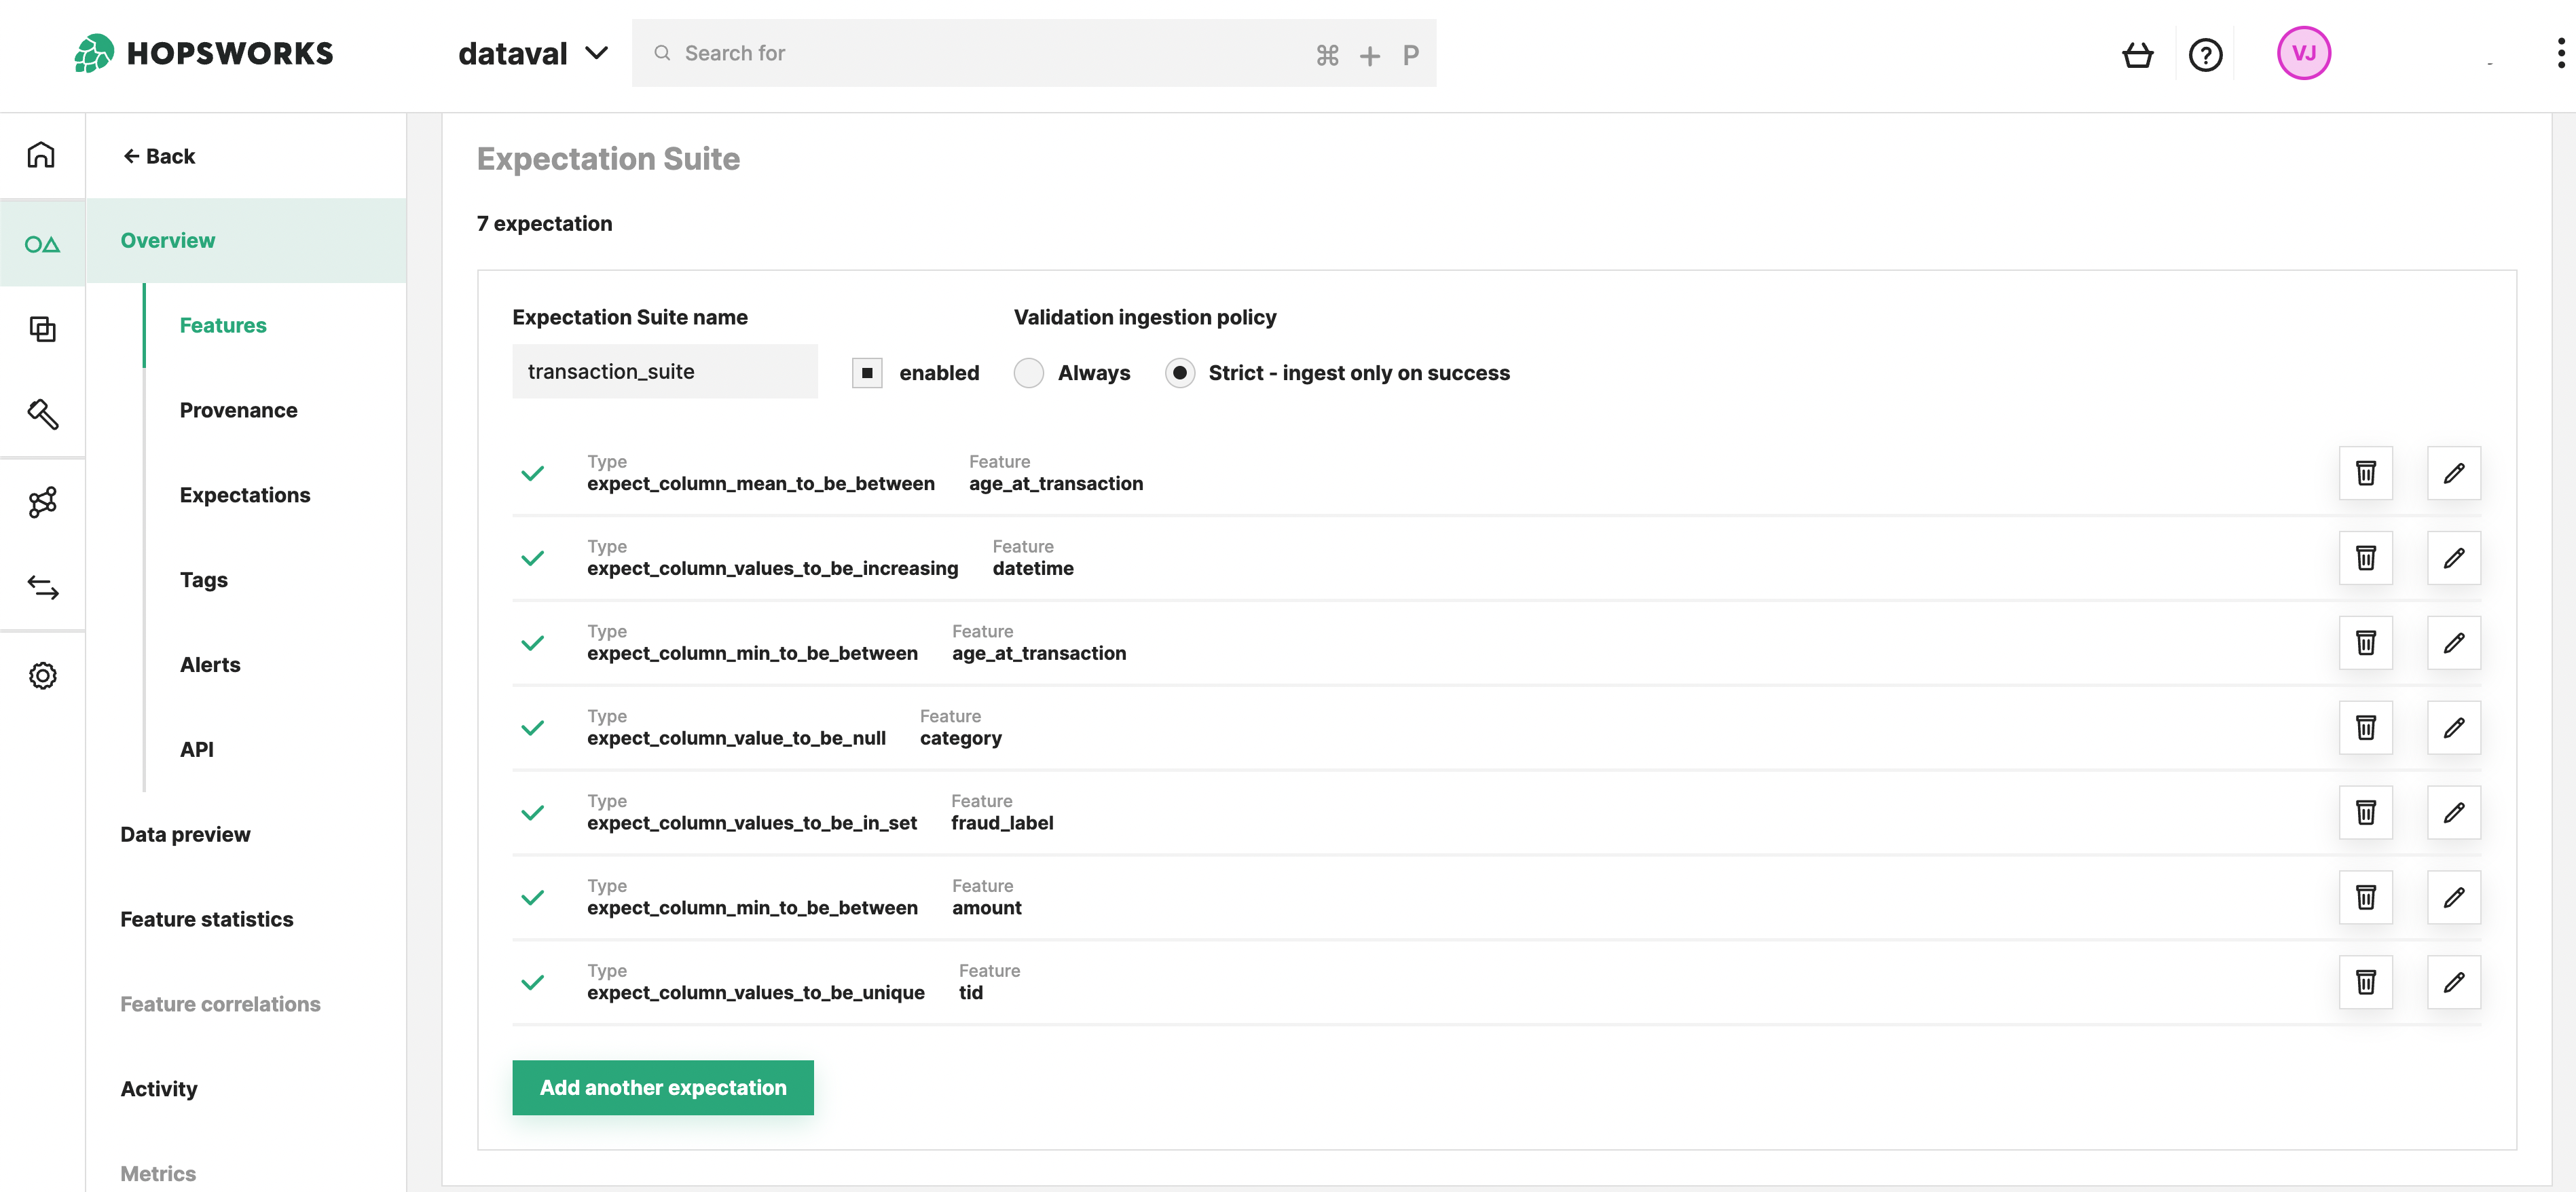

### Validation Report

On performing validation of a DataFrame using an expectation suite, Great Expectations generates a validation report. This report collects all results from the expectations ran during the validation as well as various related metadata (overall success, timestamps, version, etc...)

By default, running validation with Hopsworks uploads the validation report to the backend. Hopsworks UI provides a simple way to consult a summary of these reports or download the full report for more thorough investigation.

In [ ]:
pprint(report)

In [ ]:
# automatic validation on insertion, checkout the report in Hopsworks UI
trans_fg.insert(trans_df)

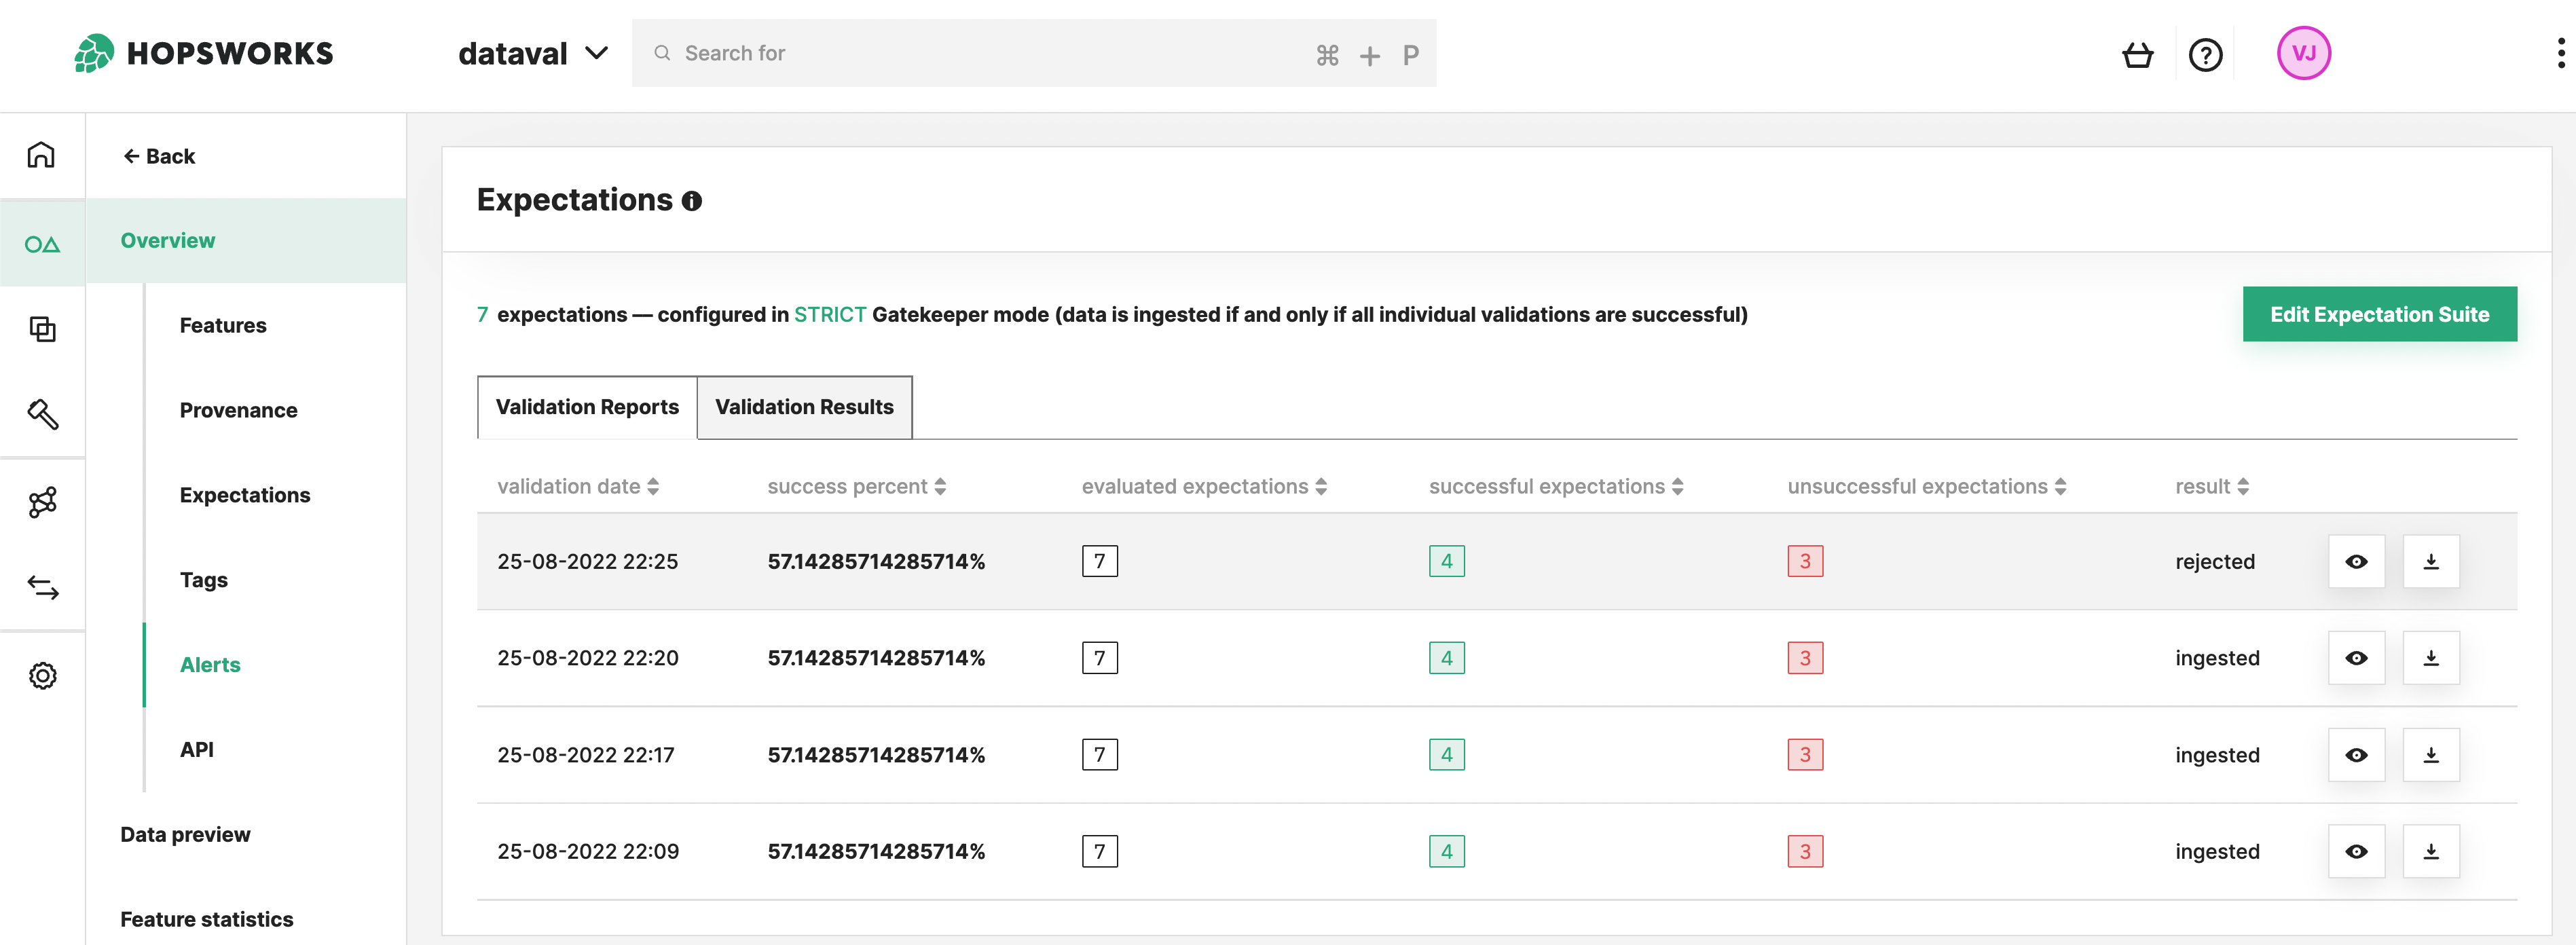

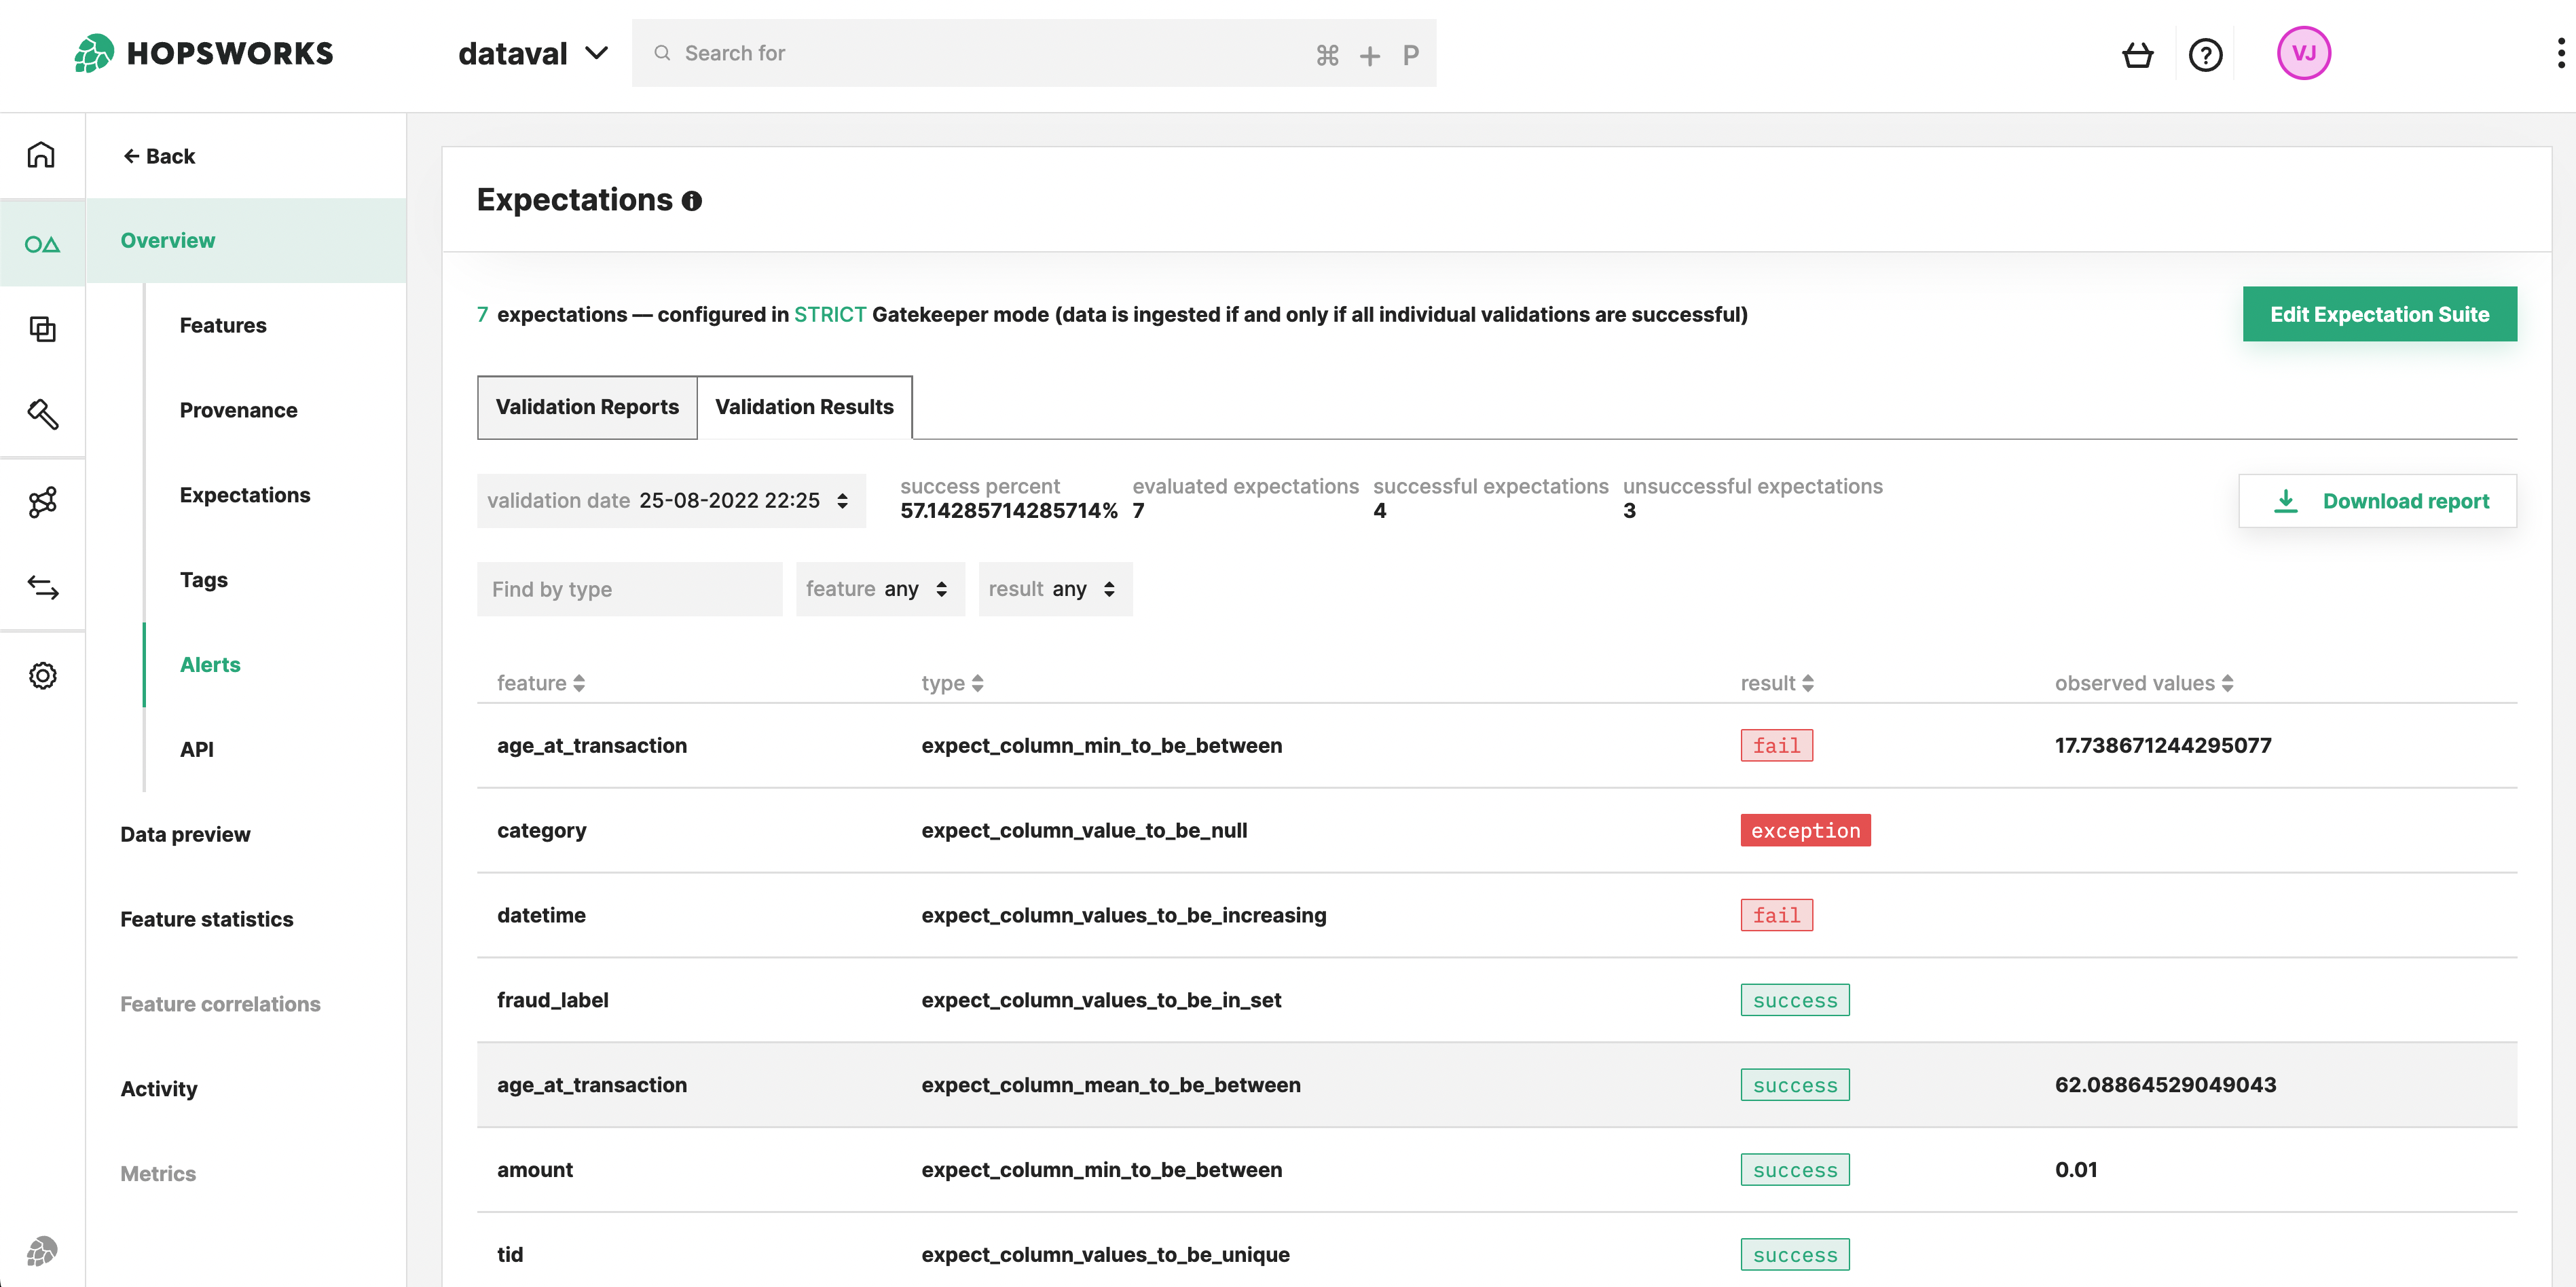

### Great Expectations Other Concepts

So far, onlyy concepts relevant to Hopsworks were explore. Great Expectations is a complex Data Validation library with a lot of great tools and concepts to be used. Checkout their documentation or glossary to learn to make the most of it.

- [Docs](https://greatexpectations.io/)
- [Glossary](https://docs.greatexpectations.io/docs/glossary)

### Next Step : Data Validation with Great Expectation applied to the Fraud tutorial

Check it out here : [![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/logicalclocks/hopsworks-tutorials/blob/master/integrations/great_expectations/fraud_batch_data_validation.ipynb)